In [14]:
def strStr(haystack: str, needle: str) -> int:
    first_letter_idx = haystack.find( needle[0] )

    if needle[0] == needle[-1]:
        last_letter_idx = haystack[first_letter_idx: ].find( needle[-1] )
        last_letter_idx = first_letter_idx + last_letter_idx + 1
    else:
        last_letter_idx = haystack.find( needle[-1] )

    if len(haystack) < len(needle): 
        return -1

    if first_letter_idx == -1 or last_letter_idx == -1:
        return -1

    if haystack[first_letter_idx: last_letter_idx + 1] == needle:
        return first_letter_idx
    
    else:
        haystack = haystack[ last_letter_idx: ]
        print('----------------')
        return strStr(haystack, needle)

In [ ]:
strStr( 'mississippi', 'issi' )

In [7]:
"abece".find("b")

1

# TASK

You are employed as a data scientist at SussexBudgetProductions. The last movie produced by the company was a comedy-action-thriller with a budget of £500K. It failed at the box office and only grossed £100K. In order to keep the production company in business, the next film needs to make money. In a senior leadership meeting, Beff Jezos (the CEO) decided that either a Romance movie or a Horror movie should be created next. As a member of the data science team, you have been tasked to produce some statistics and evidence to help decide which genre might be better, and to recommend a director and an actor to approach to design the movie around. 

The underlying assumption made by the senior leadership team is that a higher IMDB score implies a higher profit, so they are looking to create a movie that could achieve a high IMDB score. One can see that IMDB score is community driven, and so, as your manager, I am recommending that you think carefully about the number of reviews a movie has received (less reviews mean less certainty in the IMDB score). 

In [288]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import scipy
from scipy.stats import ttest_ind
from tqdm import tqdm

### Displaying Package Versions

In [289]:
print( f'Version of Pandas: {pd.__version__}' )
print( f'Version of Numpy: {np.__version__}' )
print( f'Version of Seaborn: {sns.__version__}' )
print( f'Version of Matplotlib: {np.__version__}' )
print( f'Version of Requests: {requests.__version__}' )
print( f'Version of Scipy: {scipy.__version__}' )
print( f'Version of Tqdm: 4.66.5' )

Version of Pandas: 2.2.3
Version of Numpy: 2.1.2
Version of Seaborn: 0.13.2
Version of Matplotlib: 2.1.2
Version of Requests: 2.32.3
Version of Scipy: 1.14.1
Version of Tqdm: 4.66.5


In [290]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Reading the data as demanded

In [291]:
def read_data( fname: str ) -> pd.DataFrame:
   try:
      df = pd.read_csv( fname )
      print( 'Data successfully read!' )
      return df
   except FileNotFoundError:
      print( 'File Not Found! Please check your data path again.' )
      return None
   except Exception as E:
      print( f'An error occured when reading the data: { E }' )
      return None

In [292]:
DATA_PATH = 'data/movie_metadata.csv' #* PLEASE CHANGE THIS PATH.

df = read_data( DATA_PATH )
df.head()

Data successfully read!


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.0,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens ...,8,143,NaN,0.0,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [293]:
num_of_entries, num_of_cols = df.shape
num_of_entries, num_of_cols

(5043, 28)

In [294]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

In [295]:
df.describe( include=[object] )

,color,director_name,actor_2_name,genres,actor_1_name,movie_title,actor_3_name,plot_keywords,movie_imdb_link,language,country,content_rating
count,5024,4939,5030,5043,5036,5043,5020,4890,5043,5029,5038,4740
unique,2,2398,3032,914,2097,4917,3521,4760,4919,46,65,18
top,Color,Steven Spielberg,Morgan Freeman,Drama,Robert De Niro,Ben-Hur,John Heard,based on novel,http://www.imdb.com/title/tt0232500/?ref_=fn_t...,English,USA,R
freq,4815,26,20,236,49,3,8,4,3,4704,3807,2118


In [296]:
df.describe( include=[int, float] )

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,4993.000000,5028.000000,4939.000000,5020.000000,5036.000000,4.159000e+03,5.043000e+03,5043.000000,5030.000000,5022.000000,4.551000e+03,4935.000000,5030.000000,5043.000000,4714.000000,5043.000000
mean,140.194272,107.201074,686.509212,645.009761,6560.047061,4.846841e+07,8.366816e+04,9699.063851,1.371173,272.770808,3.975262e+07,2002.470517,1651.754473,6.442138,2.220403,7525.964505
std,121.601675,25.197441,2813.328607,1665.041728,15020.759120,6.845299e+07,1.384853e+05,18163.799124,2.013576,377.982886,2.061149e+08,12.474599,4042.438863,1.125116,1.385113,19320.445110
min,1.000000,7.000000,0.000000,0.000000,0.000000,1.620000e+02,5.000000e+00,0.000000,0.000000,1.000000,2.180000e+02,1916.000000,0.000000,1.600000,1.180000,0.000000
25%,50.000000,93.000000,7.000000,133.000000,614.000000,5.340988e+06,8.593500e+03,1411.000000,0.000000,65.000000,6.000000e+06,1999.000000,281.000000,5.800000,1.850000,0.000000
50%,110.000000,103.000000,49.000000,371.500000,988.000000,2.551750e+07,3.435900e+04,3090.000000,1.000000,156.000000,2.000000e+07,2005.000000,595.000000,6.600000,2.350000,166.000000
75%,195.000000,118.000000,194.500000,636.000000,11000.000000,6.230944e+07,9.630900e+04,13756.500000,2.000000,326.000000,4.500000e+07,2011.000000,918.000000,7.200000,2.350000,3000.000000
max,813.000000,511.000000,23000.000000,23000.000000,640000.000000,7.605058e+08,1.689764e+06,656730.000000,43.000000,5060.000000,1.221550e+10,2016.000000,137000.000000,9.500000,16.000000,349000.000000


### Displaying the percentage of NULL values in each column before handling NULL values

In [297]:
for col in df.columns:
    perc = ( df[col].isnull().sum() / num_of_entries ) * 100
    print( f'{perc: .4f}% of the {col} has NULL values' )

 0.3768% of the color has NULL values
 2.0623% of the director_name has NULL values
 0.9915% of the num_critic_for_reviews has NULL values
 0.2974% of the duration has NULL values
 2.0623% of the director_facebook_likes has NULL values
 0.4561% of the actor_3_facebook_likes has NULL values
 0.2578% of the actor_2_name has NULL values
 0.1388% of the actor_1_facebook_likes has NULL values
 17.5292% of the gross has NULL values
 0.0000% of the genres has NULL values
 0.1388% of the actor_1_name has NULL values
 0.0000% of the movie_title has NULL values
 0.0000% of the num_voted_users has NULL values
 0.0000% of the cast_total_facebook_likes has NULL values
 0.4561% of the actor_3_name has NULL values
 0.2578% of the facenumber_in_poster has NULL values
 3.0339% of the plot_keywords has NULL values
 0.0000% of the movie_imdb_link has NULL values
 0.4164% of the num_user_for_reviews has NULL values
 0.2776% of the language has NULL values
 0.0991% of the country has NULL values
 6.0083% o

### A Function to handle NaN values

In [298]:
def handle_null_values(df: pd.DataFrame, col_name: str, method: str = "mean") -> pd.DataFrame:
    """
    Handle null values in a specified column of the DataFrame based on the chosen method.

    Parameters:
        df (pd.DataFrame): The DataFrame to process.
        col_name (str): The name of the column where null values should be handled.
        method (str): The method to handle nulls. Options:
                      - 'drop': Drop rows with any nulls.
                      - 'mode': Fill with the mod.
                      - 'median': Fill with the median (numerical data only).
                      - 'mean': Fill with the mean (numerical data only).

    Returns:
        pd.DataFrame: The DataFrame with nulls handled in the specified column.
    """
    
    method = method.lower()

    if method == 'drop':
        return df.dropna() 
    
    # Distinguish between object (categorical) and numerical columns
    if col_name in df.select_dtypes(include=['object']).columns:
        if method == 'mode':
            df[col_name] = df[col_name].fillna(df[col_name].mode().iloc[0])
        else:
            raise ValueError("Invalid method for object column; only 'mode' is allowed.")
    else:
        if method == 'median':
            df[col_name] = df[col_name].fillna(df[col_name].median())
        elif method == 'mean':
            df[col_name] = df[col_name].fillna(df[col_name].mean())
        else:
            raise ValueError("Invalid method for numerical column; choose 'mean' or 'median'.")
    
    return df

### Filling the NaN values in categorical & numerical columns

In [299]:
for col in df.select_dtypes(include=['object']).columns:
    df = handle_null_values( df, col, 'mode' )

In [300]:
for col in df.select_dtypes( include=['int', 'float'] ).columns:
    df = handle_null_values( df, col, 'median' )

### Displaying the percentage of NULL values in each column after handling NULL values

In [301]:
for col in df.columns:
    perc = ( df[col].isnull().sum() / num_of_entries ) * 100
    print( f'{perc: .4f}% of the {col} has NULL values' )

 0.0000% of the color has NULL values
 0.0000% of the director_name has NULL values
 0.0000% of the num_critic_for_reviews has NULL values
 0.0000% of the duration has NULL values
 0.0000% of the director_facebook_likes has NULL values
 0.0000% of the actor_3_facebook_likes has NULL values
 0.0000% of the actor_2_name has NULL values
 0.0000% of the actor_1_facebook_likes has NULL values
 0.0000% of the gross has NULL values
 0.0000% of the genres has NULL values
 0.0000% of the actor_1_name has NULL values
 0.0000% of the movie_title has NULL values
 0.0000% of the num_voted_users has NULL values
 0.0000% of the cast_total_facebook_likes has NULL values
 0.0000% of the actor_3_name has NULL values
 0.0000% of the facenumber_in_poster has NULL values
 0.0000% of the plot_keywords has NULL values
 0.0000% of the movie_imdb_link has NULL values
 0.0000% of the num_user_for_reviews has NULL values
 0.0000% of the language has NULL values
 0.0000% of the country has NULL values
 0.0000% of

In [302]:
df.shape

(5043, 28)

### Displaying top 10 movies by IMDb Score

In [346]:
top_10_movies = df.sort_values( by='imdb_score', ascending=False ).head(10)
top_10_movies[ ['movie_title', 'imdb_score', 'genres'] ]

,movie_title,imdb_score,genres
2765,Towering Inferno,9.5,Comedy
1937,The Shawshank Redemption,9.3,Crime|Drama
3466,The Godfather,9.2,Crime|Drama
4409,Kickboxer: Vengeance,9.1,Action
2824,Dekalog,9.1,Drama
3207,Dekalog,9.1,Drama
66,The Dark Knight,9.0,Action|Crime|Drama|Thriller
2837,The Godfather: Part II,9.0,Crime|Drama
3481,Fargo,9.0,Crime|Drama|Thriller
339,The Lord of the Rings: The Return of the King,8.9,Action|Adventure|Drama|Fantasy


### The top 5 individual genres (e.g., action, romance, horror, thriller) with the most number of movies, the distribution of their IMDB scores and some summary statistics

In [304]:
genres_split = df.assign(genres=df['genres'].str.split('|')).explode('genres')
top_5_genres = genres_split['genres'].value_counts().head(5)
top_5_genres_list = top_5_genres.index.tolist()
top_5_genres_df = genres_split[genres_split['genres'].isin(top_5_genres_list)]
top_5_genres_df[[ 'director_name', 'num_critic_for_reviews', 'gross', 'genres', 'movie_title']].head()

,director_name,num_critic_for_reviews,gross,genres,movie_title
0,James Cameron,723.0,760505847.0,Action,Avatar
1,Gore Verbinski,302.0,309404152.0,Action,Pirates of the Caribbean: At World's End
2,Sam Mendes,602.0,200074175.0,Action,Spectre
2,Sam Mendes,602.0,200074175.0,Thriller,Spectre
3,Christopher Nolan,813.0,448130642.0,Action,The Dark Knight Rises


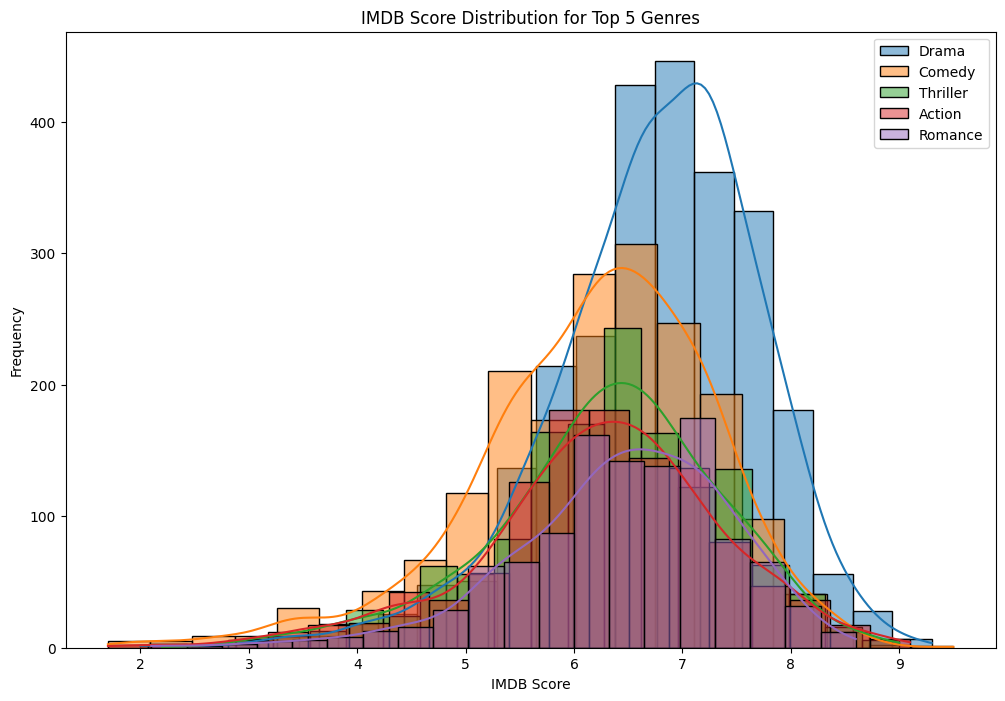


IMDB Score Summary Statistics for Top 5 Genres:


,count,mean,std,min,25%,50%,75%,max
genres,,,,,,,,
Action,1153.0,6.239896,1.118835,1.7,5.7,6.3,7.0,9.1
Comedy,1872.0,6.195246,1.090714,1.7,5.6,6.3,6.9,9.5
Drama,2594.0,6.763763,0.957354,2.0,6.2,6.9,7.4,9.3
Romance,1107.0,6.450587,0.996035,2.1,5.9,6.5,7.2,8.6
Thriller,1411.0,6.314245,1.054334,2.2,5.7,6.4,7.0,9.0


In [305]:
genre_imdb_summary = top_5_genres_df.groupby('genres')['imdb_score']

genre_summary = genre_imdb_summary.describe()

plt.figure(figsize=(12, 8))
for genre in top_5_genres_list:
    sns.histplot(top_5_genres_df[top_5_genres_df['genres'] == genre]['imdb_score'], kde=True,
             bins=20, alpha=0.5, label=genre)

plt.xlabel('IMDB Score')
plt.ylabel('Frequency')
plt.title('IMDB Score Distribution for Top 5 Genres')
plt.legend()
plt.show()

print("\nIMDB Score Summary Statistics for Top 5 Genres:")
genre_summary

### Filtering the data according to genres. If they have Horror or Romance in it, keep the row otherwise do not include to the new dataframe

In [306]:
romance_horror_df = df[df['genres'].str.contains('horror|romance', case=False, na=False)]

romance_horror_df.shape

(1655, 28)

In [307]:
romance_horror_df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
6,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,Action|Adventure|Romance,J.K. Simmons,Spider-Man 3,383056,46055,Kirsten Dunst,0.0,sandman|spider man|symbiote|venom|villain,http://www.imdb.com/title/tt0413300/?ref_=fn_t...,1902.0,English,USA,PG-13,258000000.0,2007.0,11000.0,6.2,2.35,0
7,Color,Nathan Greno,324.0,100.0,15.0,284.0,Donna Murphy,799.0,200807262.0,Adventure|Animation|Comedy|Family|Fantasy|Musi...,Brad Garrett,Tangled,294810,2036,M.C. Gainey,1.0,17th century|based on fairy tale|disney|flower...,http://www.imdb.com/title/tt0398286/?ref_=fn_t...,387.0,English,USA,PG,260000000.0,2010.0,553.0,7.8,1.85,29000
25,Color,Peter Jackson,446.0,201.0,0.0,84.0,Thomas Kretschmann,6000.0,218051260.0,Action|Adventure|Drama|Romance,Naomi Watts,King Kong,316018,7123,Evan Parke,0.0,animal name in title|ape abducts a woman|goril...,http://www.imdb.com/title/tt0360717/?ref_=fn_t...,2618.0,English,New Zealand,PG-13,207000000.0,2005.0,919.0,7.2,2.35,0
26,Color,James Cameron,315.0,194.0,0.0,794.0,Kate Winslet,29000.0,658672302.0,Drama|Romance,Leonardo DiCaprio,Titanic,793059,45223,Gloria Stuart,0.0,artist|love|ship|titanic|wet,http://www.imdb.com/title/tt0120338/?ref_=fn_t...,2528.0,English,USA,PG-13,200000000.0,1997.0,14000.0,7.7,2.35,26000
31,Color,Sam Raimi,300.0,135.0,0.0,4000.0,James Franco,24000.0,373377893.0,Action|Adventure|Fantasy|Romance,J.K. Simmons,Spider-Man 2,411164,43388,Kirsten Dunst,1.0,death|doctor|scientist|super villain|tentacle,http://www.imdb.com/title/tt0316654/?ref_=fn_t...,1303.0,English,USA,PG-13,200000000.0,2004.0,11000.0,7.3,2.35,0


In [308]:
romance_horror_df.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name', 'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name', 'movie_title', 'num_voted_users', 'cast_total_facebook_likes', 'actor_3_name', 'facenumber_in_poster', 'plot_keywords', 'movie_imdb_link', 'num_user_for_reviews', 'language', 'country', 'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes', 'imdb_score', 'aspect_ratio', 'movie_facebook_likes'], dtype='object')

### Filtering my romance_horror_df in which I can only pursue with important columns

In [309]:
romance_horror_df = romance_horror_df[ ['country','movie_title', 'title_year', 'genres', 'imdb_score', 'budget', 'gross', 'director_name', 'director_facebook_likes', 'num_critic_for_reviews', 'actor_3_name', 'actor_3_facebook_likes', 'actor_2_name', 'actor_2_facebook_likes', 'actor_1_name', 'actor_1_facebook_likes', 'movie_facebook_likes', 'cast_total_facebook_likes', 'num_voted_users'] ]

romance_horror_df.shape

(1655, 19)

In [310]:
romance_horror_df.head()

,country,movie_title,title_year,genres,imdb_score,budget,gross,director_name,director_facebook_likes,num_critic_for_reviews,actor_3_name,actor_3_facebook_likes,actor_2_name,actor_2_facebook_likes,actor_1_name,actor_1_facebook_likes,movie_facebook_likes,cast_total_facebook_likes,num_voted_users
6,USA,Spider-Man 3,2007.0,Action|Adventure|Romance,6.2,258000000.0,336530303.0,Sam Raimi,0.0,392.0,Kirsten Dunst,4000.0,James Franco,11000.0,J.K. Simmons,24000.0,0,46055,383056
7,USA,Tangled,2010.0,Adventure|Animation|Comedy|Family|Fantasy|Musi...,7.8,260000000.0,200807262.0,Nathan Greno,15.0,324.0,M.C. Gainey,284.0,Donna Murphy,553.0,Brad Garrett,799.0,29000,2036,294810
25,New Zealand,King Kong,2005.0,Action|Adventure|Drama|Romance,7.2,207000000.0,218051260.0,Peter Jackson,0.0,446.0,Evan Parke,84.0,Thomas Kretschmann,919.0,Naomi Watts,6000.0,0,7123,316018
26,USA,Titanic,1997.0,Drama|Romance,7.7,200000000.0,658672302.0,James Cameron,0.0,315.0,Gloria Stuart,794.0,Kate Winslet,14000.0,Leonardo DiCaprio,29000.0,26000,45223,793059
31,USA,Spider-Man 2,2004.0,Action|Adventure|Fantasy|Romance,7.3,200000000.0,373377893.0,Sam Raimi,0.0,300.0,Kirsten Dunst,4000.0,James Franco,11000.0,J.K. Simmons,24000.0,0,43388,411164


In [311]:
romance_horror_df.rename(columns={ 'title_year': 'release_year' }, inplace=True)

In [312]:
romance_horror_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1655 entries, 6 to 5041
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   country                    1655 non-null   object 
 1   movie_title                1655 non-null   object 
 2   release_year               1655 non-null   float64
 3   genres                     1655 non-null   object 
 4   imdb_score                 1655 non-null   float64
 5   budget                     1655 non-null   float64
 6   gross                      1655 non-null   float64
 7   director_name              1655 non-null   object 
 8   director_facebook_likes    1655 non-null   float64
 9   num_critic_for_reviews     1655 non-null   float64
 10  actor_3_name               1655 non-null   object 
 11  actor_3_facebook_likes     1655 non-null   float64
 12  actor_2_name               1655 non-null   object 
 13  actor_2_facebook_likes     1655 non-null   float64
 1

In [313]:
romance_horror_df['release_year'] = romance_horror_df['release_year'].astype(int)

In [314]:
romance_horror_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1655 entries, 6 to 5041
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   country                    1655 non-null   object 
 1   movie_title                1655 non-null   object 
 2   release_year               1655 non-null   int64  
 3   genres                     1655 non-null   object 
 4   imdb_score                 1655 non-null   float64
 5   budget                     1655 non-null   float64
 6   gross                      1655 non-null   float64
 7   director_name              1655 non-null   object 
 8   director_facebook_likes    1655 non-null   float64
 9   num_critic_for_reviews     1655 non-null   float64
 10  actor_3_name               1655 non-null   object 
 11  actor_3_facebook_likes     1655 non-null   float64
 12  actor_2_name               1655 non-null   object 
 13  actor_2_facebook_likes     1655 non-null   float64
 1

In [315]:
romance_horror_df['release_year'] = pd.to_datetime(romance_horror_df['release_year'], format='%Y').dt.year

In [316]:
romance_horror_df.head()

,country,movie_title,release_year,genres,imdb_score,budget,gross,director_name,director_facebook_likes,num_critic_for_reviews,actor_3_name,actor_3_facebook_likes,actor_2_name,actor_2_facebook_likes,actor_1_name,actor_1_facebook_likes,movie_facebook_likes,cast_total_facebook_likes,num_voted_users
6,USA,Spider-Man 3,2007,Action|Adventure|Romance,6.2,258000000.0,336530303.0,Sam Raimi,0.0,392.0,Kirsten Dunst,4000.0,James Franco,11000.0,J.K. Simmons,24000.0,0,46055,383056
7,USA,Tangled,2010,Adventure|Animation|Comedy|Family|Fantasy|Musi...,7.8,260000000.0,200807262.0,Nathan Greno,15.0,324.0,M.C. Gainey,284.0,Donna Murphy,553.0,Brad Garrett,799.0,29000,2036,294810
25,New Zealand,King Kong,2005,Action|Adventure|Drama|Romance,7.2,207000000.0,218051260.0,Peter Jackson,0.0,446.0,Evan Parke,84.0,Thomas Kretschmann,919.0,Naomi Watts,6000.0,0,7123,316018
26,USA,Titanic,1997,Drama|Romance,7.7,200000000.0,658672302.0,James Cameron,0.0,315.0,Gloria Stuart,794.0,Kate Winslet,14000.0,Leonardo DiCaprio,29000.0,26000,45223,793059
31,USA,Spider-Man 2,2004,Action|Adventure|Fantasy|Romance,7.3,200000000.0,373377893.0,Sam Raimi,0.0,300.0,Kirsten Dunst,4000.0,James Franco,11000.0,J.K. Simmons,24000.0,0,43388,411164


### Fetching the world population in the release_year

In [317]:
def get_population(year, country_name):
    """
    Retrieves the total population for a given year for a specified country from the World Bank API.

    Args:
        year (int): The year for which to retrieve the population data.
        country_name (str): The name of the country as listed in the dataset.

    Returns:
        int or None: The total population for the given year, or None if the data is not available.
    """
    
    # Country code mapping
    country_code_mapping = {
        'USA': 'USA', 'New Zealand': 'NZL', 'Australia': 'AUS', 'Belgium': 'BEL',
        'Japan': 'JPN', 'Germany': 'DEU', 'New Line': None, 'China': 'CHN',
        'UK': 'GBR', 'France': 'FRA', 'Canada': 'CAN', 'Spain': 'ESP', 'India': 'IND',
        'Peru': 'PER', 'Hong Kong': 'HKG', 'Italy': 'ITA', 'Ireland': 'IRL',
        'South Korea': 'KOR', 'Switzerland': 'CHE', 'Romania': 'ROU',
        'South Africa': 'ZAF', 'Hungary': 'HUN', 'Sweden': 'SWE', 'Taiwan': 'TWN',
        'Czech Republic': 'CZE', 'Iceland': 'ISL', 'Norway': 'NOR', 'Mexico': 'MEX',
        'Poland': 'POL', 'West Germany': 'DEU', 'Israel': 'ISR', 'Brazil': 'BRA'
    }
    
    # Get the country code from the name
    country_code = country_code_mapping.get(country_name)
    
    # If country code is not found or is None (e.g., "New Line"), return None
    if not country_code:
        print(f"Country '{country_name}' not found in mapping or not a valid country.")
        return None
    
    # Build URL for API request
    url = f"http://api.worldbank.org/v2/country/{country_code}/indicator/SP.POP.TOTL?date={year}&format=json"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        try:
            population = data[1][0]['value']
            return population
        except Exception:
            return None
    else:
        return None

In [318]:
tqdm.pandas()
#* IT IS GOING TO TAKE APPROXIMATELY 10 MINUTES TO RUN THIS CODE BLOCK.
romance_horror_df['world_population'] = romance_horror_df.progress_apply( lambda row: get_population(row['release_year'], row['country']), axis=1 )
romance_horror_df.head()

Country 'New Line' not found in mapping or not a valid country.


100%|██████████| 1655/1655 [10:14<00:00,  2.69it/s]


,country,movie_title,release_year,genres,imdb_score,budget,gross,director_name,director_facebook_likes,num_critic_for_reviews,actor_3_name,actor_3_facebook_likes,actor_2_name,actor_2_facebook_likes,actor_1_name,actor_1_facebook_likes,movie_facebook_likes,cast_total_facebook_likes,num_voted_users,world_population
6,USA,Spider-Man 3,2007,Action|Adventure|Romance,6.2,258000000.0,336530303.0,Sam Raimi,0.0,392.0,Kirsten Dunst,4000.0,James Franco,11000.0,J.K. Simmons,24000.0,0,46055,383056,301231207.0
7,USA,Tangled,2010,Adventure|Animation|Comedy|Family|Fantasy|Musi...,7.8,260000000.0,200807262.0,Nathan Greno,15.0,324.0,M.C. Gainey,284.0,Donna Murphy,553.0,Brad Garrett,799.0,29000,2036,294810,309327143.0
25,New Zealand,King Kong,2005,Action|Adventure|Drama|Romance,7.2,207000000.0,218051260.0,Peter Jackson,0.0,446.0,Evan Parke,84.0,Thomas Kretschmann,919.0,Naomi Watts,6000.0,0,7123,316018,4133900.0
26,USA,Titanic,1997,Drama|Romance,7.7,200000000.0,658672302.0,James Cameron,0.0,315.0,Gloria Stuart,794.0,Kate Winslet,14000.0,Leonardo DiCaprio,29000.0,26000,45223,793059,272657000.0
31,USA,Spider-Man 2,2004,Action|Adventure|Fantasy|Romance,7.3,200000000.0,373377893.0,Sam Raimi,0.0,300.0,Kirsten Dunst,4000.0,James Franco,11000.0,J.K. Simmons,24000.0,0,43388,411164,292805298.0


In [319]:
romance_horror_df['movie_title'] = romance_horror_df['movie_title'].str.replace('\xa0', '', regex=True)

In [320]:
romance_horror_df[ romance_horror_df['world_population'].isnull() ]

,country,movie_title,release_year,genres,imdb_score,budget,gross,director_name,director_facebook_likes,num_critic_for_reviews,actor_3_name,actor_3_facebook_likes,actor_2_name,actor_2_facebook_likes,actor_1_name,actor_1_facebook_likes,movie_facebook_likes,cast_total_facebook_likes,num_voted_users,world_population
281,New Line,Town & Country,2001,Comedy|Romance,4.4,90000000.0,6712451.0,Peter Chelsom,23.0,62.0,Garry Shandling,591.0,Warren Beatty,631.0,Del Zamora,752.0,53,3133,4102,NaN
2605,Taiwan,"Crouching Tiger, Hidden Dragon",2000,Action|Drama|Romance,7.9,15000000.0,128067808.0,Ang Lee,0.0,287.0,Sihung Lung,5.0,Pei-Pei Cheng,21.0,Chen Chang,103.0,0,129,217740,NaN
2904,USA,The Prisoner of Zenda,1937,Adventure|Drama|Romance,7.8,20000000.0,25517500.0,John Cromwell,19.0,7.0,Ronald Colman,135.0,Mary Astor,185.0,David Niven,490.0,337,1166,3256,NaN
3352,USA,Quo Vadis,1951,Biography|Drama|History|Romance,7.2,7623000.0,25517500.0,Mervyn LeRoy,54.0,54.0,Robert Taylor,346.0,Deborah Kerr,426.0,Peter Ustinov,440.0,1000,1373,9808,NaN
3596,USA,Duel in the Sun,1946,Drama|Romance|Western,6.9,8000000.0,20400000.0,King Vidor,54.0,32.0,Jennifer Jones,332.0,Lillian Gish,436.0,Joseph Cotten,469.0,403,2037,6304,NaN
3752,USA,Solomon and Sheba,1959,Drama|History|Romance|War,6.2,5000000.0,25517500.0,King Vidor,54.0,14.0,Finlay Currie,70.0,George Sanders,333.0,Gina Lollobrigida,746.0,270,1332,2017,NaN
3755,USA,A Farewell to Arms,1932,Drama|Romance|War,6.6,800000.0,25517500.0,Frank Borzage,57.0,42.0,Adolphe Menjou,99.0,Helen Hayes,164.0,Gary Cooper,998.0,213,1284,3519,NaN
3794,USA,Tycoon,1947,Adventure|Drama|Romance,6.2,3209000.0,25517500.0,Richard Wallace,5.0,9.0,Laraine Day,100.0,Paul Fix,116.0,Judith Anderson,197.0,44,538,989,NaN
3850,USA,State Fair,1945,Musical|Romance,7.1,20000000.0,25517500.0,Walter Lang,9.0,17.0,Frank McHugh,37.0,Jeanne Crain,135.0,Dana Andrews,188.0,501,496,2756,NaN
3890,USA,The Greatest Show on Earth,1952,Drama|Family|Romance,6.7,4000000.0,36000000.0,Cecil B. DeMille,309.0,44.0,Cornel Wilde,132.0,Dorothy Lamour,178.0,Gloria Grahame,232.0,625,825,9456,NaN


In [321]:
romance_horror_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1655 entries, 6 to 5041
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   country                    1655 non-null   object 
 1   movie_title                1655 non-null   object 
 2   release_year               1655 non-null   int32  
 3   genres                     1655 non-null   object 
 4   imdb_score                 1655 non-null   float64
 5   budget                     1655 non-null   float64
 6   gross                      1655 non-null   float64
 7   director_name              1655 non-null   object 
 8   director_facebook_likes    1655 non-null   float64
 9   num_critic_for_reviews     1655 non-null   float64
 10  actor_3_name               1655 non-null   object 
 11  actor_3_facebook_likes     1655 non-null   float64
 12  actor_2_name               1655 non-null   object 
 13  actor_2_facebook_likes     1655 non-null   float64
 1

### Dropping NaN Values in World Population

In [322]:
romance_horror_df = handle_null_values( df=romance_horror_df, col_name='world_population', method='drop' )

### Finding duplicated rows that has same movie_title, release_year & director_name

In [323]:
duplicated_movies = list(pd.unique( romance_horror_df[ romance_horror_df.duplicated( subset=['movie_title', 'release_year', 'director_name'])]['movie_title'] ))

number_of_duplicates = len(romance_horror_df[ romance_horror_df['movie_title'].isin(duplicated_movies) ])

print(f"Number of movies with duplicate titles: {number_of_duplicates}")

Number of movies with duplicate titles: 93


In [324]:
romance_horror_df[ romance_horror_df['movie_title'] == 'The Omen']

,country,movie_title,release_year,genres,imdb_score,budget,gross,director_name,director_facebook_likes,num_critic_for_reviews,actor_3_name,actor_3_facebook_likes,actor_2_name,actor_2_facebook_likes,actor_1_name,actor_1_facebook_likes,movie_facebook_likes,cast_total_facebook_likes,num_voted_users,world_population
1894,UK,The Omen,1976,Fantasy|Horror|Mystery,7.6,2800000.0,25517500.0,Richard Donner,503.0,154.0,Billie Whitelaw,108.0,Patrick Troughton,139.0,Lee Remick,264.0,7000,673,80958,56211968.0
4150,UK,The Omen,1976,Fantasy|Horror|Mystery,7.6,2800000.0,25517500.0,Richard Donner,503.0,154.0,Billie Whitelaw,108.0,Patrick Troughton,139.0,Lee Remick,264.0,7000,673,80961,56211968.0


In [325]:
romance_horror_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1613 entries, 6 to 5041
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   country                    1613 non-null   object 
 1   movie_title                1613 non-null   object 
 2   release_year               1613 non-null   int32  
 3   genres                     1613 non-null   object 
 4   imdb_score                 1613 non-null   float64
 5   budget                     1613 non-null   float64
 6   gross                      1613 non-null   float64
 7   director_name              1613 non-null   object 
 8   director_facebook_likes    1613 non-null   float64
 9   num_critic_for_reviews     1613 non-null   float64
 10  actor_3_name               1613 non-null   object 
 11  actor_3_facebook_likes     1613 non-null   float64
 12  actor_2_name               1613 non-null   object 
 13  actor_2_facebook_likes     1613 non-null   float64
 1

In [326]:
romance_horror_df = romance_horror_df.drop_duplicates( 'movie_title', keep='first', ignore_index=True )
romance_horror_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1564 entries, 0 to 1563
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   country                    1564 non-null   object 
 1   movie_title                1564 non-null   object 
 2   release_year               1564 non-null   int32  
 3   genres                     1564 non-null   object 
 4   imdb_score                 1564 non-null   float64
 5   budget                     1564 non-null   float64
 6   gross                      1564 non-null   float64
 7   director_name              1564 non-null   object 
 8   director_facebook_likes    1564 non-null   float64
 9   num_critic_for_reviews     1564 non-null   float64
 10  actor_3_name               1564 non-null   object 
 11  actor_3_facebook_likes     1564 non-null   float64
 12  actor_2_name               1564 non-null   object 
 13  actor_2_facebook_likes     1564 non-null   float

### Normalize facebook_likes columns since Facebook published in 2009

In [327]:
facebook_columns = [
    'director_facebook_likes', 
    'actor_1_facebook_likes', 
    'actor_2_facebook_likes', 
    'actor_3_facebook_likes', 
    'movie_facebook_likes', 
    'cast_total_facebook_likes'
]

for col in facebook_columns:
    romance_horror_df.loc[:, f'{col}_per_population']  = romance_horror_df[col] / romance_horror_df['world_population']

romance_horror_df.head()

,country,movie_title,release_year,genres,imdb_score,budget,gross,director_name,director_facebook_likes,num_critic_for_reviews,actor_3_name,actor_3_facebook_likes,actor_2_name,actor_2_facebook_likes,actor_1_name,actor_1_facebook_likes,movie_facebook_likes,cast_total_facebook_likes,num_voted_users,world_population,director_facebook_likes_per_population,actor_1_facebook_likes_per_population,actor_2_facebook_likes_per_population,actor_3_facebook_likes_per_population,movie_facebook_likes_per_population,cast_total_facebook_likes_per_population
0,USA,Spider-Man 3,2007,Action|Adventure|Romance,6.2,258000000.0,336530303.0,Sam Raimi,0.0,392.0,Kirsten Dunst,4000.0,James Franco,11000.0,J.K. Simmons,24000.0,0,46055,383056,301231207.0,0.000000e+00,0.000080,0.000037,1.327884e-05,0.000000,0.000153
1,USA,Tangled,2010,Adventure|Animation|Comedy|Family|Fantasy|Musi...,7.8,260000000.0,200807262.0,Nathan Greno,15.0,324.0,M.C. Gainey,284.0,Donna Murphy,553.0,Brad Garrett,799.0,29000,2036,294810,309327143.0,4.849235e-08,0.000003,0.000002,9.181218e-07,0.000094,0.000007
2,New Zealand,King Kong,2005,Action|Adventure|Drama|Romance,7.2,207000000.0,218051260.0,Peter Jackson,0.0,446.0,Evan Parke,84.0,Thomas Kretschmann,919.0,Naomi Watts,6000.0,0,7123,316018,4133900.0,0.000000e+00,0.001451,0.000222,2.031979e-05,0.000000,0.001723
3,USA,Titanic,1997,Drama|Romance,7.7,200000000.0,658672302.0,James Cameron,0.0,315.0,Gloria Stuart,794.0,Kate Winslet,14000.0,Leonardo DiCaprio,29000.0,26000,45223,793059,272657000.0,0.000000e+00,0.000106,0.000051,2.912084e-06,0.000095,0.000166
4,USA,Spider-Man 2,2004,Action|Adventure|Fantasy|Romance,7.3,200000000.0,373377893.0,Sam Raimi,0.0,300.0,Kirsten Dunst,4000.0,James Franco,11000.0,J.K. Simmons,24000.0,0,43388,411164,292805298.0,0.000000e+00,0.000082,0.000038,1.366096e-05,0.000000,0.000148


In [328]:
romance_horror_df[ 'revenue' ] = romance_horror_df[ 'gross' ] - romance_horror_df[ 'budget' ]
print(romance_horror_df.head())

       country   movie_title  release_year                                             genres  imdb_score       budget        gross  director_name  director_facebook_likes  num_critic_for_reviews   actor_3_name  actor_3_facebook_likes        actor_2_name  actor_2_facebook_likes       actor_1_name  actor_1_facebook_likes  movie_facebook_likes  cast_total_facebook_likes  num_voted_users  world_population  director_facebook_likes_per_population  actor_1_facebook_likes_per_population  actor_2_facebook_likes_per_population  actor_3_facebook_likes_per_population  movie_facebook_likes_per_population  cast_total_facebook_likes_per_population      revenue
0          USA  Spider-Man 3          2007                           Action|Adventure|Romance         6.2  258000000.0  336530303.0      Sam Raimi                      0.0                   392.0  Kirsten Dunst                  4000.0        James Franco                 11000.0       J.K. Simmons                 24000.0                     0  

In [329]:
romance_horror_df.drop( 'country', axis=1, inplace=True )
romance_horror_df.head()

,movie_title,release_year,genres,imdb_score,budget,gross,director_name,director_facebook_likes,num_critic_for_reviews,actor_3_name,actor_3_facebook_likes,actor_2_name,actor_2_facebook_likes,actor_1_name,actor_1_facebook_likes,movie_facebook_likes,cast_total_facebook_likes,num_voted_users,world_population,director_facebook_likes_per_population,actor_1_facebook_likes_per_population,actor_2_facebook_likes_per_population,actor_3_facebook_likes_per_population,movie_facebook_likes_per_population,cast_total_facebook_likes_per_population,revenue
0,Spider-Man 3,2007,Action|Adventure|Romance,6.2,258000000.0,336530303.0,Sam Raimi,0.0,392.0,Kirsten Dunst,4000.0,James Franco,11000.0,J.K. Simmons,24000.0,0,46055,383056,301231207.0,0.000000e+00,0.000080,0.000037,1.327884e-05,0.000000,0.000153,78530303.0
1,Tangled,2010,Adventure|Animation|Comedy|Family|Fantasy|Musi...,7.8,260000000.0,200807262.0,Nathan Greno,15.0,324.0,M.C. Gainey,284.0,Donna Murphy,553.0,Brad Garrett,799.0,29000,2036,294810,309327143.0,4.849235e-08,0.000003,0.000002,9.181218e-07,0.000094,0.000007,-59192738.0
2,King Kong,2005,Action|Adventure|Drama|Romance,7.2,207000000.0,218051260.0,Peter Jackson,0.0,446.0,Evan Parke,84.0,Thomas Kretschmann,919.0,Naomi Watts,6000.0,0,7123,316018,4133900.0,0.000000e+00,0.001451,0.000222,2.031979e-05,0.000000,0.001723,11051260.0
3,Titanic,1997,Drama|Romance,7.7,200000000.0,658672302.0,James Cameron,0.0,315.0,Gloria Stuart,794.0,Kate Winslet,14000.0,Leonardo DiCaprio,29000.0,26000,45223,793059,272657000.0,0.000000e+00,0.000106,0.000051,2.912084e-06,0.000095,0.000166,458672302.0
4,Spider-Man 2,2004,Action|Adventure|Fantasy|Romance,7.3,200000000.0,373377893.0,Sam Raimi,0.0,300.0,Kirsten Dunst,4000.0,James Franco,11000.0,J.K. Simmons,24000.0,0,43388,411164,292805298.0,0.000000e+00,0.000082,0.000038,1.366096e-05,0.000000,0.000148,173377893.0


### Visualizing the data

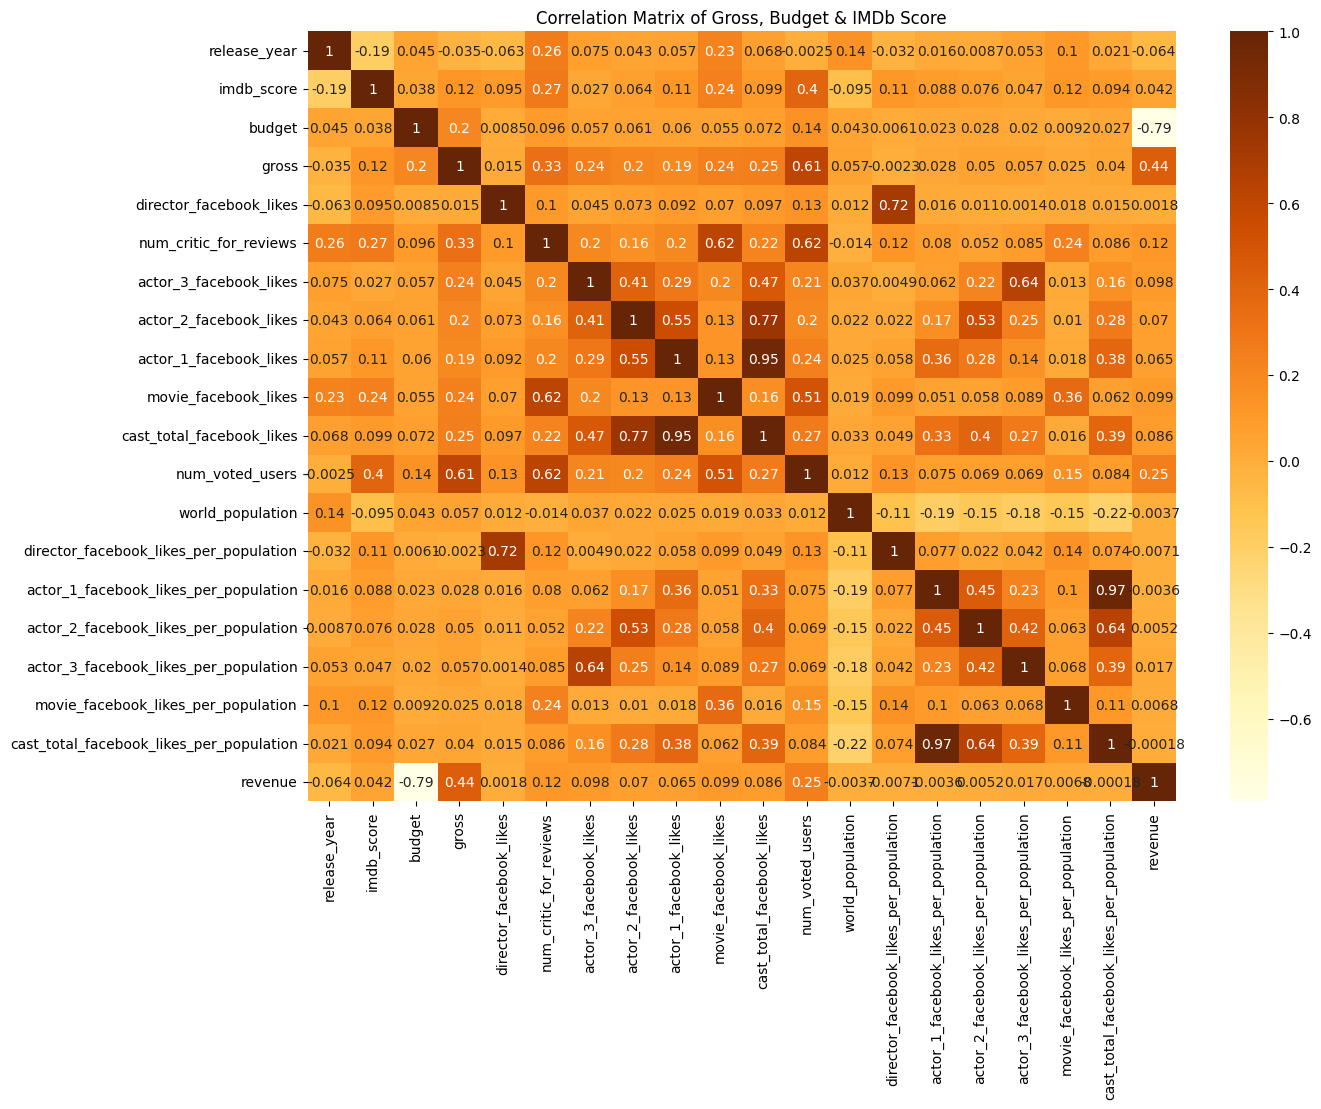

In [330]:
plt.figure(figsize=(14, 10))
sns.heatmap(romance_horror_df[ romance_horror_df.select_dtypes( include=['int', 'float']).columns ].corr(), annot=True, cmap='YlOrBr')
plt.title("Correlation Matrix of Gross, Budget & IMDb Score")
plt.show()

### I analyzed that the columns that `facebook_likes` in their names has quite weak correlation with the revenue & IMDb Score, so I am dropping them

In [331]:
cols = [ col for col in romance_horror_df.columns if 'facebook' in col ]

for col in cols:
    romance_horror_df = romance_horror_df.drop( col, axis=1 )

In [332]:
romance_horror_df[ 'revenue_per_capita' ] = romance_horror_df[ 'revenue' ] / romance_horror_df[ 'world_population' ]
print(romance_horror_df.head())

    movie_title  release_year                                             genres  imdb_score       budget        gross  director_name  num_critic_for_reviews   actor_3_name        actor_2_name       actor_1_name  num_voted_users  world_population      revenue  revenue_per_capita
0  Spider-Man 3          2007                           Action|Adventure|Romance         6.2  258000000.0  336530303.0      Sam Raimi                   392.0  Kirsten Dunst        James Franco       J.K. Simmons           383056       301231207.0   78530303.0            0.260698
1       Tangled          2010  Adventure|Animation|Comedy|Family|Fantasy|Musi...         7.8  260000000.0  200807262.0   Nathan Greno                   324.0    M.C. Gainey        Donna Murphy       Brad Garrett           294810       309327143.0  -59192738.0           -0.191360
2     King Kong          2005                     Action|Adventure|Drama|Romance         7.2  207000000.0  218051260.0  Peter Jackson                   446.0   

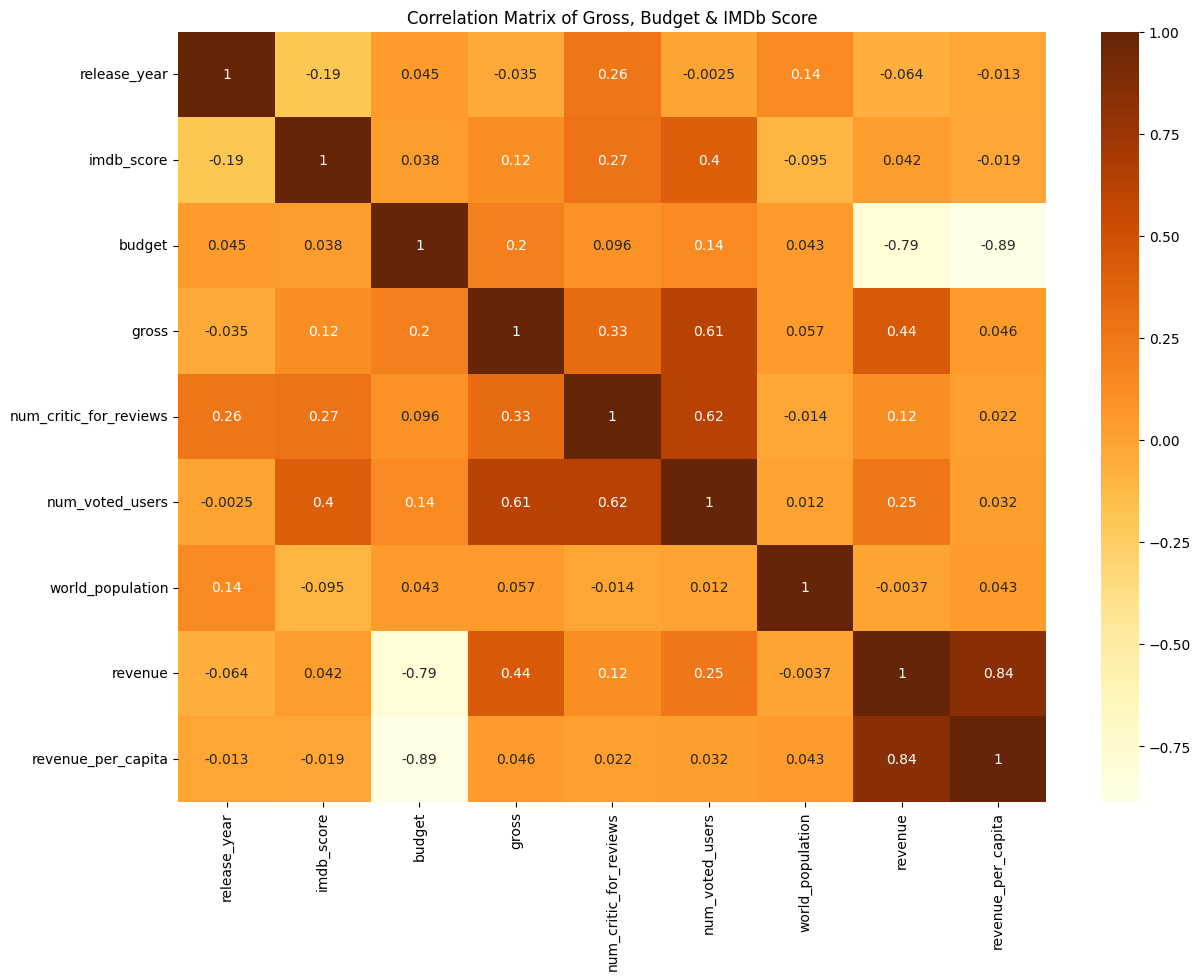

In [333]:
plt.figure(figsize=(14, 10))
sns.heatmap(romance_horror_df[ romance_horror_df.select_dtypes( include=['int', 'float']).columns ].corr(), annot=True, cmap='YlOrBr')
plt.title("Correlation Matrix of Gross, Budget & IMDb Score")
plt.show()

In [355]:
criteria = 'imdb_score'
criteria = criteria.split('_')
print( criteria )
criteria = ' '.join(criteria)
print( criteria )
criteria = criteria.title()
print( criteria )

['imdb', 'score']
imdb score
Imdb Score


In [361]:
def plot_top_directors_actors( df: pd.DataFrame, criteria: str, top_n=5 ):
    top_directors = df.groupby('director_name')[criteria].mean().sort_values(ascending=False).head(top_n)
    top_1_actors = df.groupby('actor_1_name')[criteria].mean().sort_values(ascending=False).head(top_n)
    top_2_actors = df.groupby('actor_2_name')[criteria].mean().sort_values(ascending=False).head(top_n)
    top_3_actors = df.groupby('actor_3_name')[criteria].mean().sort_values(ascending=False).head(top_n)

    criteria = criteria.split('_')
    criteria = ' '.join(criteria)
    criteria = criteria.title()

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    top_directors.plot(kind='bar', ax=axs[0, 0], color='skyblue')
    axs[0, 0].set_title( f"Top Directors by Average {criteria}")
    axs[0, 0].set_ylabel( f"Average {criteria}")
    axs[0, 0].set_xticklabels(top_directors.index, rotation=45)

    top_1_actors.plot(kind='bar', ax=axs[0, 1], color='salmon')
    axs[0, 1].set_title( f"Top Actor 1 by Average {criteria}")
    axs[0, 1].set_ylabel( f"Average {criteria}")
    axs[0, 1].set_xticklabels(top_1_actors.index, rotation=45)

    top_2_actors.plot(kind='bar', ax=axs[1, 0], color='gold')
    axs[1, 0].set_title( f"Top Actor 2 by Average {criteria}")
    axs[1, 0].set_ylabel( f"Average {criteria}")
    axs[1, 0].set_xticklabels(top_2_actors.index, rotation=45)

    top_3_actors.plot(kind='bar', ax=axs[1, 1], color='yellowgreen')
    axs[1, 1].set_title( f"Top Actor 3 by Average {criteria}")
    axs[1, 1].set_ylabel( f"Average {criteria}")
    axs[1, 1].set_xticklabels(top_3_actors.index, rotation=45)

    plt.tight_layout()
    plt.show()

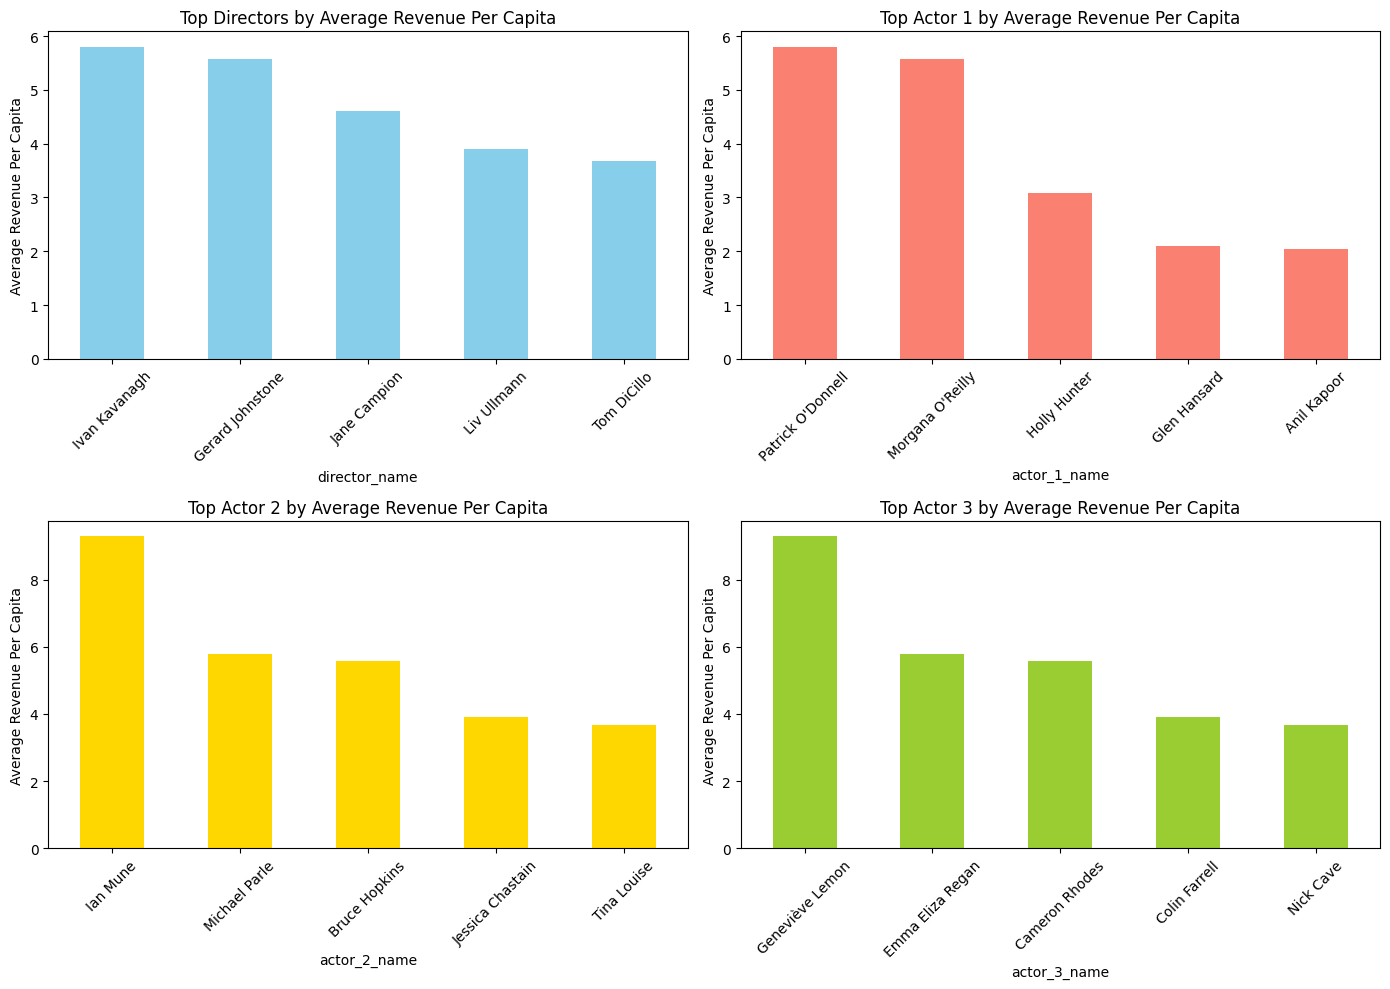

In [362]:
plot_top_directors_actors( romance_horror_df, 'revenue_per_capita' )

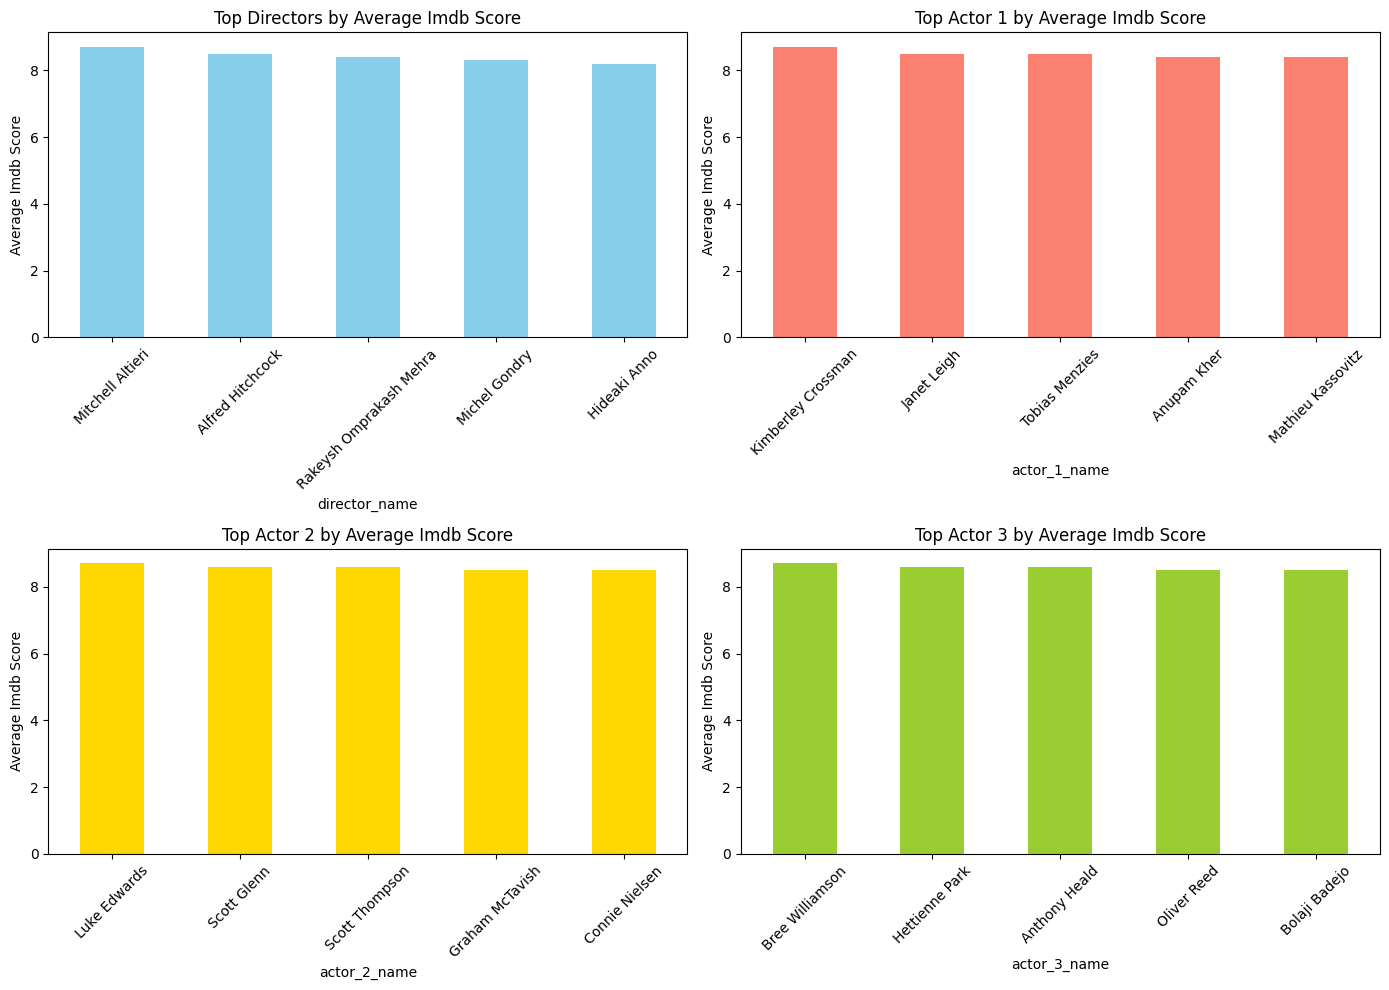

In [363]:
plot_top_directors_actors( romance_horror_df, 'imdb_score' )

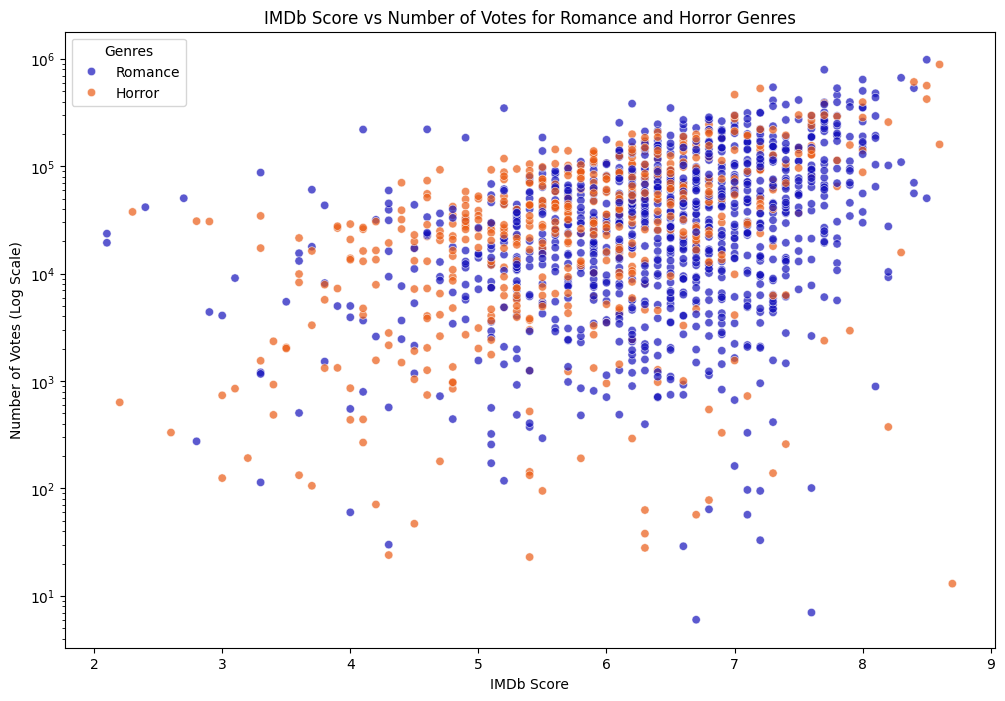

In [360]:
genres_split = romance_horror_df.assign(genres=romance_horror_df['genres'].str.split('|')).explode('genres')
filtered_df = genres_split[genres_split['genres'].isin(['Romance', 'Horror'])]
# IMDb Score vs Number of Votes for Romance and Horror Genres - Log Scale
plt.figure(figsize=(12, 8))
sns.scatterplot(data=filtered_df, x='imdb_score', y='num_voted_users', hue='genres', alpha=0.7, palette=['#1512bbbc', '#eb5c15'])
plt.yscale("log") 
plt.title("IMDb Score vs Number of Votes for Romance and Horror Genres")
plt.xlabel("IMDb Score")
plt.ylabel("Number of Votes (Log Scale)")
plt.legend(title="Genres")
plt.show()

### Hypothesis Testing for Movie Genre Revenue

We aim to test if the mean revenue of Romance movies is greater than that of Horror movies.

### Hypotheses

- **Null Hypothesis (H0):** The mean revenue of Romance movies is equal to the mean revenue of Horror movies.

  \begin{align*}
  \mathbf{H}_0 \quad &: \quad \mu_{\text{revenue, Romance}} - \mu_{\text{revenue, Horror}} = 0 \\
  \end{align*}
- **Alternative Hypothesis (H1):** The mean revenue of Romance movies is greater than the mean revenue of Horror movies.



  \begin{align*}
  \mathbf{H}_1 \quad &: \quad \mu_{\text{revenue, Romance}} - \mu_{\text{revenue, Horror}} \gt 0 \\
  \end{align*}

### Test Description

We will use a one-sided t-test to determine if the mean revenue of Romance movies is significantly higher than that of Horror movies. The significance level (\(\alpha\)) will be set at 0.05.

### Decision Rule

- **If p-value < 0.05**: Reject the null hypothesis (H0), concluding that Romance movies have a significantly higher mean revenue than Horror movies.
- **If p-value >= 0.05**: Fail to reject the null hypothesis (H0), concluding that there is no significant evidence that Romance movies have higher mean revenue than Horror movies.


In [338]:
romance_horror_df.shape

(1564, 15)

In [339]:
romance_df = romance_horror_df[romance_horror_df['genres'].str.contains('Romance', na=False)]
horror_df = romance_horror_df[romance_horror_df['genres'].str.contains('Horror', na=False)]

romance_df.shape, horror_df.shape

((1043, 15), (538, 15))

In [340]:
romance_avg_revenue_per_capita = romance_df['revenue_per_capita'].mean()
horror_avg_revenue_per_capita = horror_df['revenue_per_capita'].mean()

print(f"Romance Average Revenue Per Capita: {romance_avg_revenue_per_capita: .5f}")
print(f"Horror Average Revenue Per Capita: {horror_avg_revenue_per_capita: .5f}")

Romance Average Revenue Per Capita: -0.23965
Horror Average Revenue Per Capita:  0.08325


In [345]:
t_stat, p_value = ttest_ind(romance_df['revenue_per_capita'], horror_df['revenue_per_capita'], alternative='greater', equal_var=False)
print("T-Statistic:", t_stat)
print("P-Value:", p_value)

if p_value < 0.05:
    print("Reject the null hypothesis (H0): Romance movies have a significantly higher mean revenue_per_capita than Horror movies.")
else:
    print("Fail to reject the null hypothesis (H0): No significant evidence that Romance movies have higher mean revenue_per_capita than Horror movies.")


T-Statistic: -1.3393929310597197
P-Value: 0.9096347540100786
Fail to reject the null hypothesis (H0): No significant evidence that Romance movies have higher mean revenue_per_capita than Horror movies.


### Hypothesis Testing for Movie Genre IMDb Score

We aim to test if the mean imdb_score of Romance movies is greater than that of Horror movies.

### Hypotheses

- **Null Hypothesis (H0):** The mean imdb_score of Romance movies is equal to the mean imdb_score of Horror movies.

  \begin{align*}
  \mathbf{H}_0 \quad &: \quad \mu_{\text{imdbScore, Romance}} - \mu_{\text{imdbScore, Horror}} = 0 \\
  \end{align*}
- **Alternative Hypothesis (H1):** The mean imdb_score of Romance movies is greater than the mean imdb_score of Horror movies.



  \begin{align*}
  \mathbf{H}_1 \quad &: \quad \mu_{\text{imdbScore, Romance}} - \mu_{\text{imdbScore, Horror}} \gt 0 \\
  \end{align*}

### Test Description

We will use a one-sided t-test to determine if the mean imdb_score of Romance movies is significantly higher than that of Horror movies. The significance level (\(\alpha\)) will be set at 0.05.

### Decision Rule

- **If p-value < 0.05**: Reject the null hypothesis (H0), concluding that Romance movies have a significantly higher mean imdb_score than Horror movies.
- **If p-value >= 0.05**: Fail to reject the null hypothesis (H0), concluding that there is no significant evidence that Romance movies have higher mean imdb_score than Horror movies.


In [342]:
romance_avg_imdb = romance_df['imdb_score'].mean()
horror_avg_imdb = horror_df['imdb_score'].mean()

print(f"Romance Average IMDB Score: {romance_avg_imdb}")
print(f"Horror Average IMDB Score: {horror_avg_imdb}")

Romance Average IMDB Score: 6.411025886864813
Horror Average IMDB Score: 5.800743494423792


In [343]:
t_stat, p_value = ttest_ind(romance_df['imdb_score'], horror_df['imdb_score'], alternative='greater', equal_var=False)
print("T-Statistic ( IMDb Score ):", t_stat)
print("P-Value ( IMDb Score ):", p_value)

if p_value < 0.05:
    print("Reject the null hypothesis (H0): Romance movies have a significantly higher mean imdb_score than Horror movies.")
else:
    print("Fail to reject the null hypothesis (H0): No significant evidence that Romance movies have higher mean imdb_score than Horror movies.")


T-Statistic ( IMDb Score ): 10.673456509513956
P-Value ( IMDb Score ): 1.5816670359309433e-25
Reject the null hypothesis (H0): Romance movies have a significantly higher mean imdb_score than Horror movies.


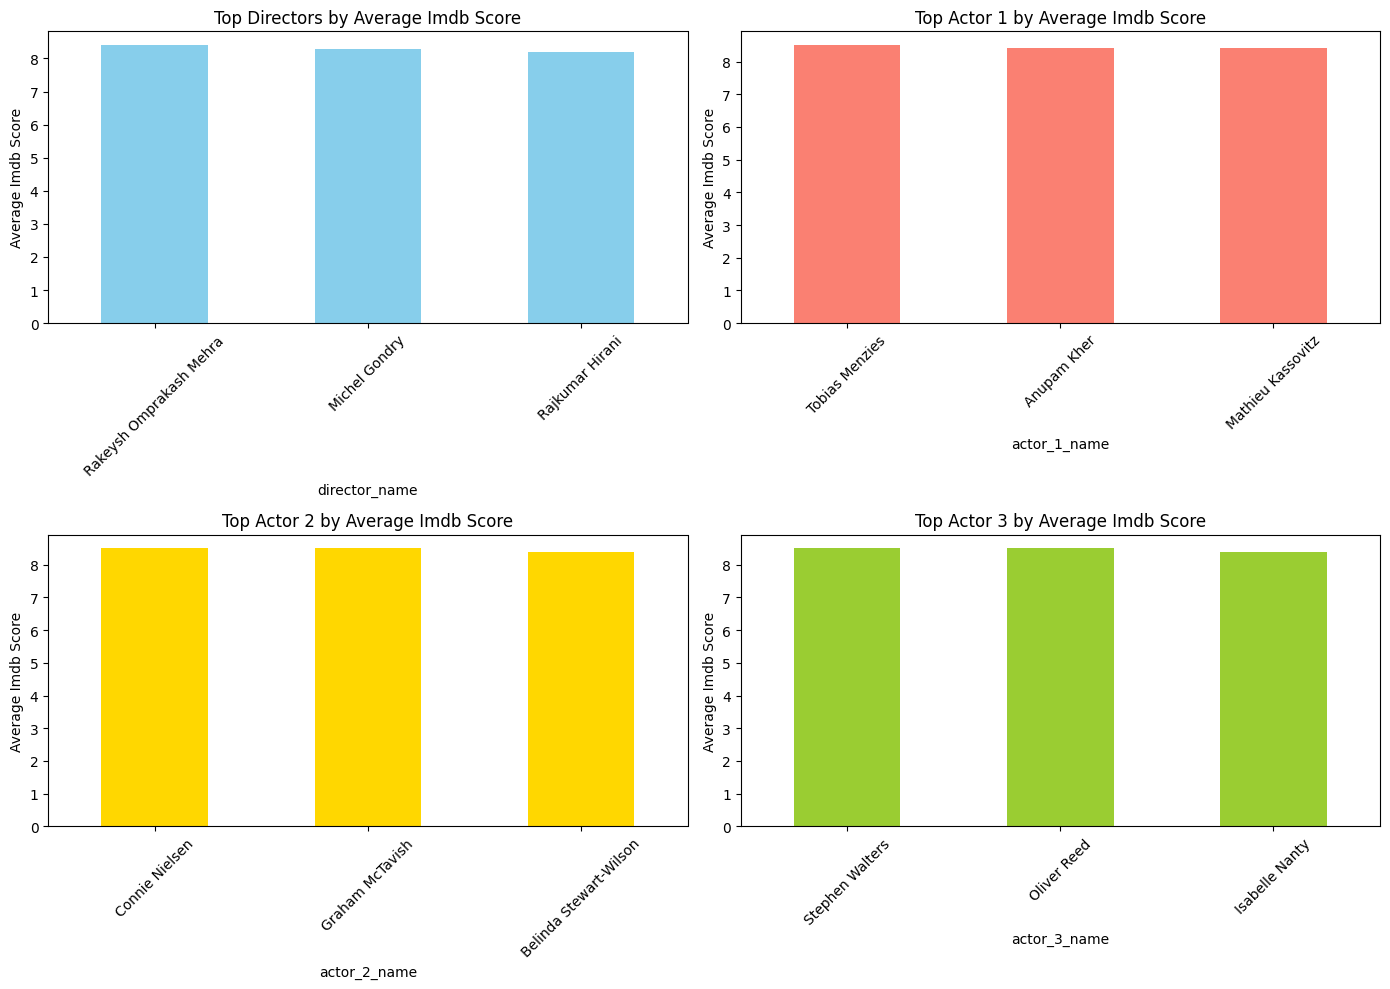

In [365]:
plot_top_directors_actors( romance_df, 'imdb_score', 3 )

### CONCLUSION

&rarr; The Hypothesis Testing that is applied on Revenue per Capita did not give the expected results, since it is obvious that the revenues of Romance are much higher than Horror movies. That is why, I applied a second Hypothesis test that assumes IMDb Score would be a significance of profit of any movie. The results of this hyptohesis tests give the expected results.

&rarr; In conclusion, for the next movie shot, it is best to perform a **`Romance`** movie. 